In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [2]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [3]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Better Buy: Amazon vs. Ulta Beauty
Sep-26-20 11:19AM  
GameStop Investors Need to Look Beyond the Console Upgrades
09:12AM  
What to Know Before You Buy Etsy Stock
08:49AM  
Better Buy: MercadoLibre vs. Amazon
07:45AM  


In [4]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AMZN', 'Sep-26-20', '11:19AM', 'Better Buy: Amazon vs. Ulta Beauty'],
 ['AMZN',
  'Sep-26-20',
  '09:12AM',
  'GameStop Investors Need to Look Beyond the Console Upgrades'],
 ['AMZN', 'Sep-26-20', '08:49AM', 'What to Know Before You Buy Etsy Stock'],
 ['AMZN', 'Sep-26-20', '07:45AM', 'Better Buy: MercadoLibre vs. Amazon'],
 ['AMZN',
  'Sep-26-20',
  '06:30AM',
  'We Ask Successful Investors: If You Could Only Own 3 Stocks, What Would They Be?'],
 ['AMZN', 'Sep-26-20', '04:21AM', 'Point/Counterpoint: The Case for Peloton'],
 ['AMZN',
  'Sep-25-20',
  '08:19PM',
  'The Stock Market Had a Bad Week. At Least It Wasnt a Terrible One.'],
 ['AMZN',
  'Sep-25-20',
  '08:05PM',
  'Why Rival Bike Peddlers Could Help Boost Pelotons Stock'],
 ['AMZN',
  'Sep-25-20',
  '04:25PM',
  'Netflix Inc. stock outperforms market on strong trading day'],
 ['AMZN',
  'Sep-25-20',
  '04:25PM',
  'Amazon.com Inc. stock rises Friday, outperforms market'],
 ['AMZN',
  'Sep-25-20',
  '04:25PM',
  '3M Co. stock 

In [5]:
import nltk
nltk.downloader.download('vader_lexicon')
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

scores_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ravi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,neg,neu,pos,compound
0,0.000,0.263,0.737,0.8126
1,0.000,1.000,0.000,0.0000
2,0.000,1.000,0.000,0.0000
3,0.000,0.395,0.605,0.5574
4,0.000,0.774,0.226,0.5859
...,...,...,...,...
295,0.000,0.490,0.510,0.6369
296,0.146,0.854,0.000,-0.0516
297,0.000,1.000,0.000,0.0000
298,0.000,1.000,0.000,0.0000


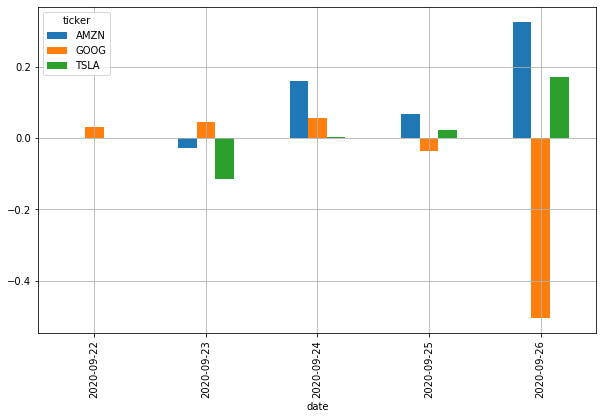

In [6]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()